[Back to Session 19](../s19_SQL_III.ipynb)

# 15 Days of SQL Challenge on HackerRank
Users of the [HackerRank website](https://www.hackerrank.com) are able to complete small coding challanges in several different languages, including SQL. One of the challenges is the [15 Days of SQL](https://www.hackerrank.com/challenges/15-days-of-learning-sql/problem) challenge. 

This notebook uses window queries, which are not currently supported by the version of SQLite provided by Google Colab. Therefore the queries in this notebook will cause errors on Google Colab.

## I. Problem Description
A fictional character named Julia conducted a ***15** Days of Learning SQL* contest. Contestents, i.e. hackers, were tasked to write challenging SQL queries over a span of 15 days. There were several SQL challenges each day for which hackers could submit their SQL queries. The start date of the contest was March 01, 2016 and the end date was March 15, 2016.

Write a query to print total number of unique hackers who made at least **1** submission each day (starting on the first day of the contest), and find the hacker_id and name of the hacker who made maximum number of submissions each day. If more than one such hacker has a maximum number of submissions, print the lowest hacker_id. The query should print this information for each day of the contest, sorted by the date.

### A. Tables
The following tables hold contest data

#### Hackers
The hacker_id is the id of the hacker, and name is the name of the hacker.

| Column    | Type    |
|-----------|---------|
| hacker_id | Integer |
| name      | String  |

#### Submissions
The submission_date is the date of the submission, submission_id is the id of the submission, hacker_id is the id of the hacker who made the submission, and score is the score of the submission.

| Column          | Type    |
|-----------------|---------|
| submission_date | Date    |
| submission_id   | Integer |
| hacker_id       | Integer |
| score           | Integer |

### B. Sample Data
#### Hackers

| hacker_id | name       |
|-----------|------------|
| 580       | Faux       |
| 517       | Pontoriero |
| 614       | Ritch      |
| 231       | Sandelin   |
| 620       | Leadman    |
| 333       | Withrow    |
| 910       | Supple     |
| 911       | Shoeman    |

#### Submissions
**Note:** This example is from the test database, in which the first day of the competition was November 1st, 2021 (not March 1st, 2016, as it is on HackerRank). In the test database, the competition only lasted for four days.

| submission_id | hacker_id | submission_date | score |
|---------------|-----------|-----------------|-------|
| 4102          | 580       | 2021-11-01      |	43    |
| 8198          | 580       | 2021-11-01      |	64    |	
| 6664          | 517       | 2021-11-01      |	41    |
| 7178          | 517       | 2021-11-01      |	45    |
| 6539          | 517       | 2021-11-01      |	44    |
| 4876          | 614       | 2021-11-01      |	42    |
| 4236          | 614       | 2021-11-01      |	33    |
| 3218          | 614       | 2021-11-01      |	77    |
| 4501          | 614       | 2021-11-01      |	89    |
| 5910          | 620       | 2021-11-01      |	69    |
| 6677          | 910       | 2021-11-01      |	59    |
| 7325          | 910       | 2021-11-01      |	84    |
| 8606          | 911       | 2021-11-01      |	88    |
| 6814          | 475       | 2021-11-01      |	8     |
| 1184          | 830       | 2021-11-01      |	98    |
| 8733          | 580       | 2021-11-02      |	64    |
| 1060          | 517       | 2021-11-02      |	4     |
| 6827          | 614       | 2021-11-02      |	88    |

### C. Sample Output

| submission_date | qty_hackers	| hacker_id |  name    |
|-----------------|-------------|-----------|----------|
| 2021-11-01      | 8           | 614       | Ritch    |
| 2021-11-02      | 7           | 911       | Shoeman  |
| 2021-11-03      | 5           | 231       | Sandelin |
| 2021-11-04      | 3           | 475       | Zwicker  |

### D. Explanation
* On November 1st 2021, there were eight hackers who submitted SQL queries: 580, 517, 614, 620, 910, 911, 475, and 830. Hacker 614 is the hacker who made the most submissions.
* On November 2nd, of the eight hackers who made submissions on the 1st, all but hacker 910 made a submission. The number of hackers who submitted on all days of the competition has dropped to 7. Of these, hacker 911 made the most submissions, at 3. 
* The number of hackers who have submitted each day continues to drop until the final day of the competion, on the 4th of November. On the final day, both hacker 614 and 475 have made three submissions. Since hacker 475 has the lower hacker_id, hacker 475's name is listed in the results.

## II. Setup

### A. Create the Dataset
Users can run their SQL queries on the HackerRank website by typing them into a text box. HackerRank's website connects to a small SQL database that contains the tables needed to run the query. HackerRank's SQL interface has limitations and it's difficult to develop a complicated query using their interface. I created my own SQLite database with the same schema and randomly generated data so I could experiment with various SQL queries in a Jupyter notebook. The database is contained in the file *sql15days.sqlite3*. [The code used to create the database is in this notebook.](GenSQLData15Days.ipynb)

### B. *Ipython-sql* Extension for Jupyter Notebooks
This demo uses the *ipython-sql* package to run SQL queries in notebook cells. Run this command to install *ipython-sql* using *conda*:
```bash
conda install -c conda-forge ipython-sql
```
We have to enable the *ipython-sql* extension before we can use it.

In [2]:
# Enable ipython-sql extension
%load_ext sql

Next, we need to connect to the SQLite database.

In [3]:
# Connect to database
%sql sqlite:///sql15days.sqlite3 

'Connected: @sql15days.sqlite3'

[Additional guidance on using *ipython-sql* is available on the extension's homepage.](https://pypi.org/project/ipython-sql/)

In [4]:
import datetime
import random
import sqlite3

import pandas as pd

In [5]:
con = sqlite3.connect("sql15days.sqlite3")

## III. The Answer
There are many different queries that meet the requirements of the HackerRank challenge. Here is one such query that works in SQLite or PostgreSQL.
```sql
    WITH Ranks AS (
        SELECT Submissions.*,
               DENSE_RANK() OVER(ORDER BY submission_date)
                            AS date_rank,
               DENSE_RANK() OVER(PARTITION BY hacker_id ORDER BY submission_date)
                            AS hacker_rank
          FROM Submissions
      ORDER BY hacker_id, submission_date),
      
    Retention AS (
        SELECT submission_date, COUNT(DISTINCT hacker_id) qty_hackers
          FROM Ranks
         WHERE hacker_rank = date_rank  
      GROUP BY submission_date, date_rank, hacker_rank
    ),
    
    Submission_Quantities AS (
        SELECT submission_date, hacker_id, COUNT(*) qty_submissions
          FROM Submissions
      GROUP BY submission_date, hacker_id
    ),
    
    Max_Submissions AS (
        SELECT submission_date, MAX(qty_submissions) max_submission_qty
          FROM Submission_Quantities
      GROUP BY submission_date),
    
    Daily_Data AS (
        SELECT SQ.submission_date, R.qty_hackers,
               MIN(SQ.hacker_id) hacker_id
          FROM Retention R
    INNER JOIN Submission_Quantities SQ
               ON R.submission_date = SQ.submission_date
    INNER JOIN Max_Submissions MS
                ON SQ.submission_date = MS.submission_date
               AND SQ.qty_submissions = MS.max_submission_qty
      GROUP BY SQ.submission_date, R.qty_hackers)
    
    -- Add Hacker name to Daily_data and sort
    SELECT Daily_Data.*, name
      FROM Daily_Data
INNER JOIN Hackers
           ON Daily_Data.hacker_id = Hackers.hacker_id
     ORDER BY submission_date;
```
We're going to build this query in small steps. Before we do, it would be interesting to visualize how all of the sub-queries relate to each other. 

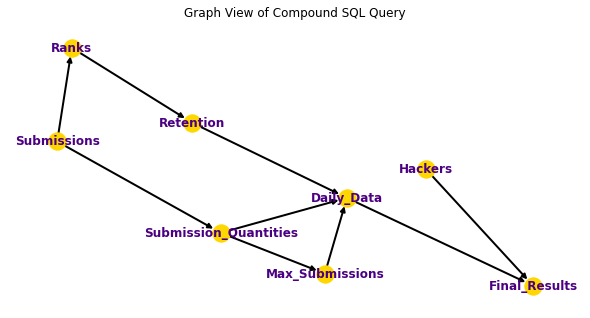

In [6]:
# Visualize the 15 Days of SQL Query
import matplotlib.pyplot as plt
import networkx as nx
import random

# Visualize the Query with a Graph Diagram
tables = [
    'Submissions', 'Ranks', 'Retention', 'Submission_Quantities',
    'Max_Submissions', 'Daily_Data', 'Hackers', 'Final_Results']
# Edge direction is from source to result
# i.e., from table in `FROM` clause to name of resulting table in `WITH` clause
relationships = [
    ('Submissions', 'Ranks'), ('Ranks', 'Retention'),
    ('Submissions', 'Submission_Quantities'),
    ('Submission_Quantities', 'Max_Submissions'),
    ('Retention', 'Daily_Data'), ('Submission_Quantities', 'Daily_Data'),
    ('Max_Submissions', 'Daily_Data'),
    ('Hackers', 'Final_Results'), ('Daily_Data', 'Final_Results')
]
sql_graph = nx.DiGraph()
sql_graph.add_nodes_from(tables)
sql_graph.add_edges_from(relationships)
plt.figure(figsize=(8, 4))
nx.draw(sql_graph, pos=nx.spring_layout(sql_graph, seed=20),
        with_labels=True,
        font_weight='bold', font_color='indigo',
        node_color='gold', width=2)
plt.title('Graph View of Compound SQL Query')
plt.show()

Each gold circle represents a table, either a table that is defined in the database schema, or an intermediate virtual table created by one of the sub-queries.  Each arrow represents a relation between two tables. Each arrow points from a source table to a results table. Tables that occur in `FROM` clauses are source tables, and the named-subqueries and final query results are the results tables.

Per graph terminology, the tables are *nodes* and the relationships (i.e., arrows) are *edges*. This graph is a directed graph because each edge has a direction (the direction in which the arrow points). 

Most source tables are used in only one results table. The *Submission_Quantities* table is used in two different results tables. One benefit of the `WITH` syntax is that we can use a source table multiple times, but we only have to define it once.

## IV. Ranks Query
First, we'll use a window query to add a *date_rank* and *hacker_rank* column to each submission, using the `DENSE_RANK()` window function.
* *date_rank*: Day 1 of the competition is assigned rank 1, day 2 is assigned rank 2, etc.
* *hacker_rank*: The first day that a hacker made a submission is assigned rank 1, regardless of the date. The second day on which a hacker made a submission is assigned rank 2.

If a hacker has made a submissio on every day of the competition up to the current submission date, then *date_rank = hacker_rank*. I added an `ORDER BY` clause to make it easier to see how the rank columns behave. The `ORDER BY` clause will not be in the final query.

In [7]:
%%sql
-- Ranks Query

SELECT Submissions.*,
       DENSE_RANK() OVER(ORDER BY submission_date) AS date_rank,
       DENSE_RANK() OVER(PARTITION BY hacker_id ORDER BY submission_date) AS hacker_rank
FROM Submissions
ORDER BY hacker_id, submission_date;

 * sqlite:///sql15days.sqlite3
Done.


submission_id,hacker_id,submission_date,score,date_rank,hacker_rank
3527,231,2021-11-03,99,3,1
5062,231,2021-11-03,88,3,1
1230,231,2021-11-03,17,3,1
7378,231,2021-11-03,39,3,1
9044,333,2021-11-03,68,3,1
1262,333,2021-11-04,53,4,2
5566,369,2021-11-02,1,2,1
7261,369,2021-11-03,84,3,2
2289,369,2021-11-04,92,4,3
8308,369,2021-11-04,61,4,3


## V. Retention Query
The *Retention* query uses the *Ranks* query to count the number of hackers who have submitted on every day of the competition, up to the current *submission_date*. The `WHERE hacker_rank = date_rank` eliminates hackers who have missed a submission date.

In [8]:
%%sql
-- Retention Query

WITH Ranks AS (
        SELECT Submissions.*,
               DENSE_RANK() OVER(ORDER BY submission_date) AS date_rank,
               DENSE_RANK() OVER(PARTITION BY hacker_id ORDER BY submission_date) AS hacker_rank
          FROM Submissions
      ORDER BY hacker_id, submission_date)

  SELECT submission_date, COUNT(DISTINCT hacker_id) qty_hackers
    FROM Ranks
   WHERE hacker_rank = date_rank  
GROUP BY submission_date, date_rank, hacker_rank;

 * sqlite:///sql15days.sqlite3
Done.


submission_date,qty_hackers
2021-11-01,8
2021-11-02,7
2021-11-03,5
2021-11-04,3


## VI. Submission_Quantities Query
Gets the number of submissions for each hacker and day.

In [9]:
%%sql
-- Submission_Quantities Query

    SELECT submission_date, hacker_id, COUNT(*) qty_submissions
      FROM Submissions
  GROUP BY submission_date, hacker_id;

 * sqlite:///sql15days.sqlite3
Done.


submission_date,hacker_id,qty_submissions
2021-11-01,475,1
2021-11-01,517,3
2021-11-01,580,2
2021-11-01,614,4
2021-11-01,620,1
2021-11-01,830,1
2021-11-01,910,2
2021-11-01,911,1
2021-11-02,369,1
2021-11-02,475,1


## VII. Lowest HackerID (Retention + Submission_Quantities)
This query joins the *Retention* and *Submission_Quantities* tables and has the following columns:
* *submission_date*: There is one row for each submission_date, thanks to the `GROUP BY` clause.
* *qty_hackers*: This is pulled from the *Retention* table.
* *hacker_id*: This is the smallest hacker_id that made a submission on the specified submission_date. But there are a couple problems with this column. The smallest hacker_id is extracted, regardless of whether they made the most submissions on that day or whether they submitted on every day. For the 2nd of Novermber, hacker 369 did NOT submit on the prior day, nor did they make the most submissions. So this data is not what we want. We want the smallest hacker_id only for the hackers who have submitted on every day and made the most submissions on that day (smallest hacker_id is a tie-breaker).

In [10]:
%%sql
    -- Lowest HackerID

    WITH Ranks AS (
        SELECT Submissions.*,
               DENSE_RANK() OVER(ORDER BY submission_date) AS date_rank,
               DENSE_RANK() OVER(PARTITION BY hacker_id ORDER BY submission_date) AS hacker_rank
          FROM Submissions
      ORDER BY hacker_id, submission_date),
      
    Retention AS (
        SELECT submission_date, COUNT(DISTINCT hacker_id) qty_hackers
          FROM Ranks
         WHERE hacker_rank = date_rank  
      GROUP BY submission_date, date_rank, hacker_rank
    ),
    
    Submission_Quantities AS (
        SELECT submission_date, hacker_id, COUNT(*) qty_submissions
          FROM Submissions
      GROUP BY submission_date, hacker_id
    )
    
    SELECT SQ.submission_date, R.qty_hackers,
           MIN(SQ.hacker_id) hacker_id
      FROM Retention R INNER JOIN Submission_Quantities SQ ON R.submission_date = SQ.submission_date
    GROUP BY SQ.submission_date, R.qty_hackers;

 * sqlite:///sql15days.sqlite3
Done.


submission_date,qty_hackers,hacker_id
2021-11-01,8,475
2021-11-02,7,369
2021-11-03,5,231
2021-11-04,3,333


## VIII. Max_Submissions Query
This query uses the *Submission_Quantities* query we already built and generates the maximum number of submissions for a given submission_date. This data is still not quite what we want, because the hacker who made the maximum number of submissions on any given day might not have made submissions on every preceding day.

In [11]:
%%sql
    -- We're re-using Submission_Quantities to generate Max_Submissions
    WITH Submission_Quantities AS (
        SELECT submission_date, hacker_id, COUNT(*) qty_submissions
          FROM Submissions
      GROUP BY submission_date, hacker_id
    )
    
    -- Max_Submissions
    SELECT submission_date, MAX(qty_submissions) max_submission_qty
      FROM Submission_Quantities
  GROUP BY submission_date;

 * sqlite:///sql15days.sqlite3
Done.


submission_date,max_submission_qty
2021-11-01,4
2021-11-02,3
2021-11-03,4
2021-11-04,3


## IX. Lowest *hacker_id* of Hackers With Maximum Daily Submissions
This query gets us closer to what we want. It displays the lowest hacker_id of all hackers who made the most submissions for that day. However the hacker might not have made submissions on all prior days.

In [12]:
%%sql
    -- Lowest ID of Hacker with max submissions

    WITH Ranks AS (
        SELECT Submissions.*,
               DENSE_RANK() OVER(ORDER BY submission_date) AS date_rank,
               DENSE_RANK() OVER(PARTITION BY hacker_id ORDER BY submission_date) AS hacker_rank
          FROM Submissions
      ORDER BY hacker_id, submission_date),
      
    Retention AS (
        SELECT submission_date, COUNT(DISTINCT hacker_id) qty_hackers
          FROM Ranks
         WHERE hacker_rank = date_rank  
      GROUP BY submission_date, date_rank, hacker_rank
    ),
    
    Submission_Quantities AS (
        SELECT submission_date, hacker_id, COUNT(*) qty_submissions
          FROM Submissions
      GROUP BY submission_date, hacker_id
    ),
    
    Max_Submissions AS (
        SELECT submission_date, MAX(qty_submissions) max_submission_qty
          FROM Submission_Quantities
      GROUP BY submission_date)
    
    SELECT SQ.submission_date, R.qty_hackers,
           MIN(SQ.hacker_id) hacker_id
      FROM Retention R
INNER JOIN Submission_Quantities SQ
           ON R.submission_date = SQ.submission_date
INNER JOIN Max_Submissions MS
            ON SQ.submission_date = MS.submission_date
           AND SQ.qty_submissions = MS.max_submission_qty
  GROUP BY SQ.submission_date, R.qty_hackers;

 * sqlite:///sql15days.sqlite3
Done.


submission_date,qty_hackers,hacker_id
2021-11-01,8,614
2021-11-02,7,911
2021-11-03,5,231
2021-11-04,3,475


### X. Final Query
The final query, which will work on HackerRank if the database type is set to *Oracle*, is below.

In [13]:
%%sql
    -- Final Query
    /* Returns the submission_date, the number of hackers who have
       completed a submission for the current and each preceding day of the
       competition, and the name and hacker_id of the hacker who made the
       most submissions on that day (this hacker need not have made a
       submission on each preceding day).
    */

    WITH Ranks AS (
        SELECT Submissions.*,
               DENSE_RANK() OVER(ORDER BY submission_date)
                            AS date_rank,
               DENSE_RANK() OVER(PARTITION BY hacker_id ORDER BY submission_date)
                            AS hacker_rank
          FROM Submissions
      ORDER BY hacker_id, submission_date),
    
    Retention AS (
        SELECT submission_date, COUNT(DISTINCT hacker_id) qty_hackers
          FROM Ranks
         WHERE hacker_rank = date_rank  
      GROUP BY submission_date, date_rank, hacker_rank
    ),
    
    Submission_Quantities AS (
        SELECT submission_date, hacker_id, COUNT(*) qty_submissions
          FROM Submissions
      GROUP BY submission_date, hacker_id
    ),
    
    Max_Submissions AS (
        SELECT submission_date, MAX(qty_submissions) max_submission_qty
          FROM Submission_Quantities
      GROUP BY submission_date),
    
    Daily_Data AS (
        SELECT SQ.submission_date, R.qty_hackers,
               MIN(SQ.hacker_id) hacker_id
          FROM Retention R
    INNER JOIN Submission_Quantities SQ
               ON R.submission_date = SQ.submission_date
    INNER JOIN Max_Submissions MS
                ON SQ.submission_date = MS.submission_date
               AND SQ.qty_submissions = MS.max_submission_qty
      GROUP BY SQ.submission_date, R.qty_hackers)
    
    -- Add Hacker name to Daily_data and sort
    SELECT Daily_Data.*, name
      FROM Daily_Data
INNER JOIN Hackers
           ON Daily_Data.hacker_id = Hackers.hacker_id
     ORDER BY submission_date;

 * sqlite:///sql15days.sqlite3
Done.


submission_date,qty_hackers,hacker_id,name
2021-11-01,8,614,Ritch
2021-11-02,7,911,Shoeman
2021-11-03,5,231,Sandelin
2021-11-04,3,475,Zwicker


[Back to Session 19](../s19_SQL_III.ipynb)